# MCMC regression demo
This methodology has not completed WRI's review process and should not be used for any purpose.

Direct questions to Ted Wong (ted.wong@wri.org).

## Problem: How to estimate future probability distributions of climate-hazard indicators
* Data source: climate simulations
    * These are global rasters of CMIP6 simulations. Outputs include daily maxtemp, mintemp, precip, and humidity for every day in years 1950-2100.
    * Downscale product is [NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). Resolution is 0.25 degrees, or approx. 25 km.
* Additional data: satellite observations
    * This is the [ERA5 reanalysis product](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), which provides similar variables and resolution for 1940-present.
    * This dataset is not used in the proposed methodology below, but it is available if useful.
    
* Using the simulated variables, for any year we can calculate numerous climate-hazard indicators for any location. Example indicators:
     * Number of days in a year with maxtemp > 35C
     * Duration of longest uninterrupted dryspell in a year
     * Number of degree-days between final frost and first frost in a year
* For a given location and future year, we would like to estimate either...
    * Probability distributions of indicator magnitudes
    * or the probability that the indicator magnitude exceeds a given threshold
* Considerations
    * Ease of calculation
        * Use cases include implementation a a web application for on-demand calculation, and precalculation of large-area rasters. We hope to use methods that lend themselves well to parallelization.
        * We would like to be able to assess the quality of our probability estimates.

## Proposed solution: Bayesian linear regression via MCMC
We propose to estimate the regression parameters $\beta_0$ and $\beta_1$ in the equation
$$
y = \beta_0 + \beta_1x
$$
where $y$ is the future indicator value, and $x$ is the historical indicator value. The regression-parameter estimation would be based on simulation outputs. We would then apply these regression parameters to $x_{hist}$ from the ERA5 data to get an estimate of the future inddicator value.

A demo implementation appears below. It is based on [this article](https://towardsdatascience.com/implementing-bayesian-linear-regression-9375a9994f98) by Javier Fernandez.

We used a non-informative prior with
* Normal intercept
* Half-Cauchy slope
* Half-Cauchy $\sigma$

and a likelihood function based on a Normal error:
* $\mu = intercept + slope\cdot x$
* $y \sim N(\mu, \sigma)$

We use the Hamiltonian MC No U-Turn Sampler (NUTS) implemented in pymc3 to take 10000 samples from the posterior distribution. The samples yield a distribution of regression parameters (slope and intercept). We propose to apply these parameter distributions to the historical satellite observations to estimate distributions of the indicator value in the future.

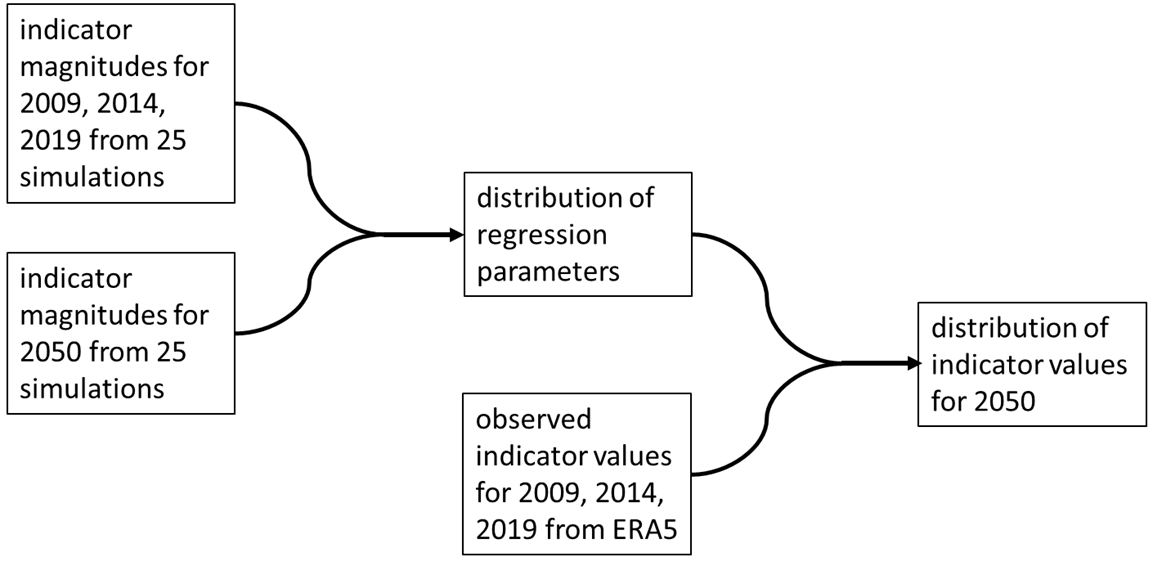

## Questions
* Is this overall approach valid?
* Are there ways we can improve the quality of the estimate? For example, could the historical data or data from different simulation years be used to increase the number of data points in the regression?


# Demo implementation

### Import libraries set authentication credentials, etc.

In [1]:
import ee
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy import stats

import datetime, calendar
import pystac_client
import fsspec
import planetary_computer
import xarray as xr

credfile = open('credentials.txt')
pc_key = credfile.readlines()[0].split('\t')[1].strip()
planetary_computer.settings.set_subscription_key(pc_key)
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
collection = catalog.get_collection("nasa-nex-gddp-cmip6")

import aesara
import pymc3 as pm

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AWtgzh61WNaHm5VPxSEw40VZdN-g9YYAKPL6ri0GxDBFEEJzxOLBpcUb55A

Successfully saved authorization token.


--------------------------
### Select CMIP6 models and define a location and future year of interest

In [3]:
LEAPLENGTH = {'UKESM1-0-LL': 360,
 'NorESM2-MM': 365,
 'NorESM2-LM': 365,
 'MRI-ESM2-0': 366,
 'MPI-ESM1-2-LR': 366,
 'MPI-ESM1-2-HR': 366,
 'MIROC6': 366,
 'MIROC-ES2L': 366,
 'KIOST-ESM': 365,
 'KACE-1-0-G': 360,
 'IPSL-CM6A-LR': 366,
 'INM-CM5-0': 365,
 'INM-CM4-8': 365,
 'HadGEM3-GC31-MM': 360,
 'HadGEM3-GC31-LL': 360,
 'GFDL-ESM4': 365,
 'GFDL-CM4_gr2': 365,
 'GFDL-CM4': 365,
 'FGOALS-g3': 365,
 'EC-Earth3-Veg-LR': 366,
 'EC-Earth3': 366,
 'CanESM5': 365,
 'CNRM-ESM2-1': 366,
 'CNRM-CM6-1': 366,
 'CMCC-ESM2': 365,
 'CMCC-CM2-SR5': 365,
 'BCC-CSM2-MR': 365,
 'ACCESS-ESM1-5': 366,
 'ACCESS-CM2': 366,
 'TaiESM1': 365,
 'ERA5': 366
}

EXCLUDED_MODELS = ['TaiESM1', 'ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in LEAPLENGTH.keys() if not i in EXCLUDED_MODELS]

INITIAL_LATLON = (22.75, 87.82)
INITIAL_WINDOW = ('04-15', '09-10')
HIST_YEARS = (2009, 2014, 2019)
FUTURE_YEAR = 2050

--------------------------------------
### Define indicator of interest
This indicator counts the number of days in the year with maximum temperature >= 35C

In [4]:
indicators = {
    'dtg34': {
            'name': 'dtg34',
            'greaterthan': True,
            'nex_varname': 'tasmax',
            'era5_varname': 'maximum_2m_air_temperature',
            'range': [1, 365, 1],
            'nex_multiply': 1,
            'nex_add': -273.15,
            'era5_multiply': 1,
            'era5_add': -273.15,
            'function': lambda windowdata: np.sum(windowdata >= 35, axis=1)
    } 
}

def indicator_magnitudes(lat, lon, window, year, indicator):
    
    def d2j(datestring):
        d = datetime.date.fromisoformat(datestring)
        jday = d.timetuple().tm_yday
        if calendar.isleap(d.year) and jday > 59:
            jday -= 1
        return jday
    
    geom = {
        'type': 'Point',
        'coordinates': [lon, lat]
    }
    nex_varname = indicator['nex_varname']
    indicator_fxn = indicator['function']
    window_start, window_end = window
    thevar = []
    for model in MODELS:
        print('value', 'Collecting model projections.<br><br>{0} / {1}'.format(MODELS.index(model) + 1, len(MODELS)))
        scenario = ["historical", "ssp585"][int(year > 2014)]
        search = catalog.search(
            collections=["nasa-nex-gddp-cmip6"],
            datetime="{0}/{0}".format(year),
            intersects = geom,
            query={"cmip6:model": {"eq": model}, "cmip6:scenario": {"eq": scenario}},
        )
        items = search.get_all_items()
        if items:
            item = items[0]
            if nex_varname in list(item.assets.keys()):
                signed_item = planetary_computer.sign(item)
                href = signed_item.assets[nex_varname].href
                openf = fsspec.open(href).open()
                data = xr.open_dataset(openf)
                localdata = data.sel(lat=lat, lon=lon, method='nearest')
                if LEAPLENGTH[model] > 360:
                    startj = d2j("{0}-{1}".format(year, window_start))
                    endj = d2j("{0}-{1}".format(year, window_end))
                    localwindowdata = (localdata.variables[nex_varname][startj-1:endj] * indicator['nex_multiply']) + indicator['nex_add']
                    thevar.append(indicator_fxn(np.array([localwindowdata])))
    return np.array([i[0] for i in thevar])

----------------------------------
### Get data points
1. For three historical years (2009, 2014, 2019), calculate the indicator. Average them. Do this for each CMIP6 model.
2. Also calculate the indicator for the future year of interest.
3. The data points are $\{x_i, y_i\}$ where $x_i =$ the mean of the historical values from model $i$ and $y_i =$ model $i$'s indicator value for the future year.

In [7]:
xs_by_year = []
for year in HIST_YEARS:
    print(year)
    xs_by_year.append(indicator_magnitudes(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, year, indicators['dtg34']))
xs_by_year = np.array(xs_by_year)
xsmean = xs_by_year.mean(axis=0)

ys = indicator_magnitudes(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_YEAR, indicators['dtg34'])

2009
value Collecting model projections.<br><br>1 / 29
value Collecting model projections.<br><br>2 / 29
value Collecting model projections.<br><br>3 / 29
value Collecting model projections.<br><br>4 / 29
value Collecting model projections.<br><br>5 / 29
value Collecting model projections.<br><br>6 / 29
value Collecting model projections.<br><br>7 / 29
value Collecting model projections.<br><br>8 / 29
value Collecting model projections.<br><br>9 / 29
value Collecting model projections.<br><br>10 / 29
value Collecting model projections.<br><br>11 / 29
value Collecting model projections.<br><br>12 / 29
value Collecting model projections.<br><br>13 / 29
value Collecting model projections.<br><br>14 / 29
value Collecting model projections.<br><br>15 / 29
value Collecting model projections.<br><br>16 / 29
value Collecting model projections.<br><br>17 / 29
value Collecting model projections.<br><br>18 / 29
value Collecting model projections.<br><br>19 / 29
value Collecting model projections.

In [10]:
ys, xsmean

(array([ 61,  80,  98,  44,  60,  65,  95,  46,  52,  74,  67,  39,  92,
         97,  79,  86,  46, 103,  53,  76,  49,  64,  92,  61,  94]),
 array([57.66666667, 62.        , 48.33333333, 50.66666667, 71.33333333,
        59.        , 55.33333333, 49.66666667, 68.66666667, 48.66666667,
        58.33333333, 60.33333333, 58.33333333, 55.        , 55.33333333,
        58.        , 52.        , 67.66666667, 62.        , 60.        ,
        60.66666667, 36.66666667, 65.66666667, 58.        , 59.        ]))

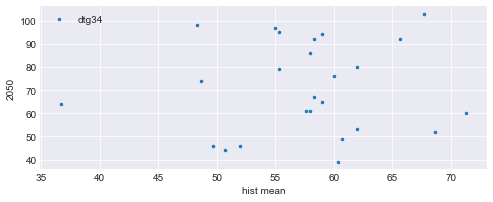

In [19]:
fig, ax = plt.subplots(figsize=(8,3))
ax.errorbar(xsmean, ys, fmt='.', label="dtg34", ms=5)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("hist mean")
ax.set_ylabel("2050");

-------------------------------
### Define Bayesian model and run MCMC
* Non-informative priors
* Normal likelihood

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 853 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


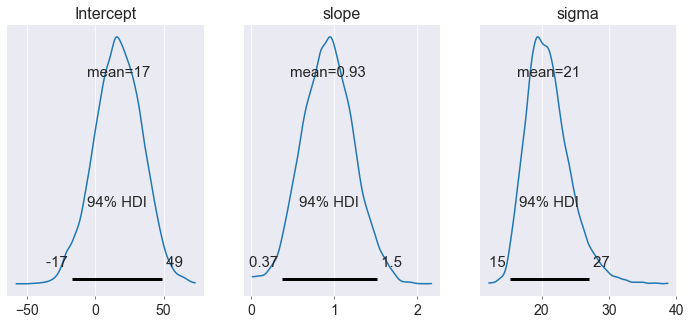

In [32]:
with pm.Model() as model:
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    slope = pm.HalfCauchy('slope', beta=10, testval=1.0)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    
    # Estimate of mean
    mu = intercept + slope * xsmean
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=ys)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    trace = pm.sample(10000, step)
pm.plot_posterior(trace, figsize = (12, 5));

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


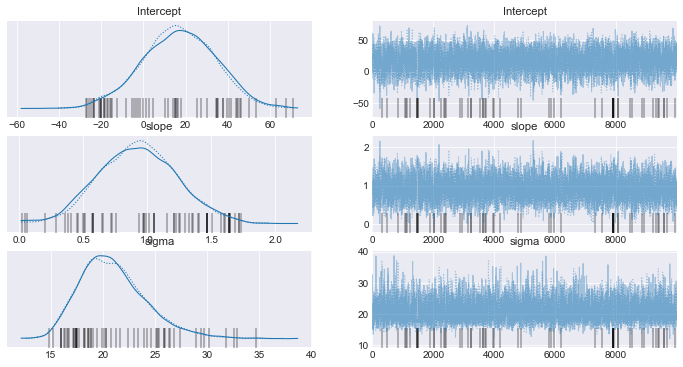

In [33]:
pm.plot_trace(trace);

In [34]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,16.821,17.383,-16.868,48.504,0.301,0.213,3351.0,2471.0,1.0
slope,0.928,0.307,0.370,1.513,0.005,0.004,3411.0,3046.0,1.0
sigma,21.011,3.284,15.227,27.043,0.044,0.031,5140.0,4042.0,1.0


----------------------
### Apply results to observed historical values
1. Calculate indicator values from ERA5 observations
2. Use slopes and intercepts from the MCMC samples to map observed values to future values
3. Characterize future values

In [46]:
def era5_indicator_magnitudes(lat, lon, years, window, indicator):
    era5_varname = indicator['era5_varname']
    is_forecast = era5_varname == "precipitation_amount_1hour_Accumulation"
    indicator_fxn = indicator['function']
    startmonth, endmonth = datetime.datetime.strptime(window[0], '%m-%d').month, datetime.datetime.strptime(window[1], '%m-%d').month

    gee_geom = ee.Geometry.Point((lon, lat))

    allyears = []
    for year in years:
        window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
        window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 

        era5_varname = indicator['era5_varname']
        ERA5 = ee.ImageCollection("ECMWF/ERA5/DAILY")
        era5_vars = ERA5.select(era5_varname)


        yeardata = pd.DataFrame(era5_vars.filterDate(window_start.strftime('%Y-%m-%d'), window_end_plusone.strftime('%Y-%m-%d')).getRegion(gee_geom, 25000, 'epsg:4326').getInfo())[4][1:]

        allyears.append(yeardata)
    return indicator_fxn((np.array(allyears) * indicator['era5_multiply']) + indicator['era5_add'])

obs_vals = era5_indicator_magnitudes(INITIAL_LATLON[0], INITIAL_LATLON[1], HIST_YEARS, INITIAL_WINDOW, indicators['dtg34'])
obs_mean = obs_vals.mean()

{'whiskers': [<matplotlib.lines.Line2D at 0x1a14b600760>,
 'caps': [<matplotlib.lines.Line2D at 0x1a14b600d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a14b600490>],
 'medians': [<matplotlib.lines.Line2D at 0x1a14b60b2e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a14b60b5b0>],
 'means': []}

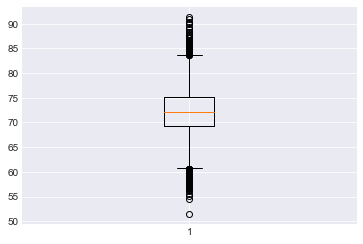

In [51]:
slopes = trace.get_values('slope')
intercepts = trace.get_values('Intercept')
future_vals = (intercepts + (slopes * obs_mean))
plt.boxplot(future_vals)

In [52]:
from scipy import stats
stats.describe(future_vals)

DescribeResult(nobs=20000, minmax=(51.37080601955782, 91.42059854898707), mean=72.22113885966549, variance=19.369730541381795, skewness=0.05290961467660695, kurtosis=0.26401988804704946)